In [ ]:
!pip install category_encoders

Loading data...
Fitting preprocessing...
Train shape: (1022825, 9), Test shape: (255707, 9)
Running Grid Search...


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'max_depth': 20, 'n_estimators': 100}
Random Forest Model Performance: MAE=35.23 RMSE=79.92 R2=0.9444
Results saved to results_rf.txt and plots saved as PNG files.


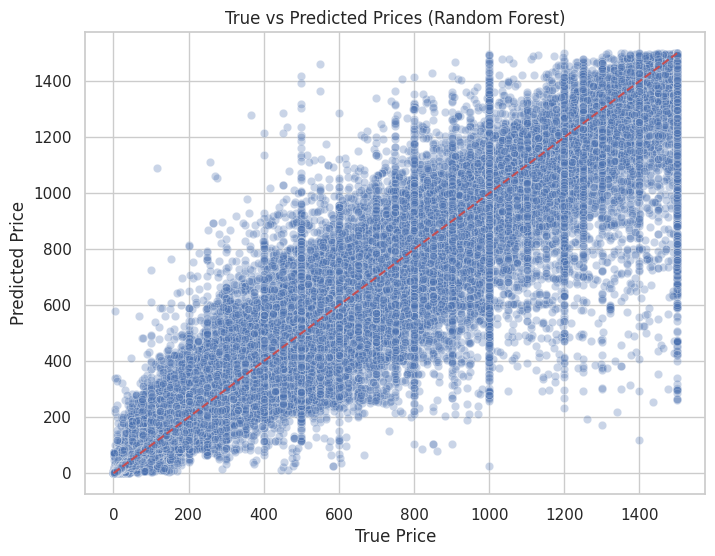

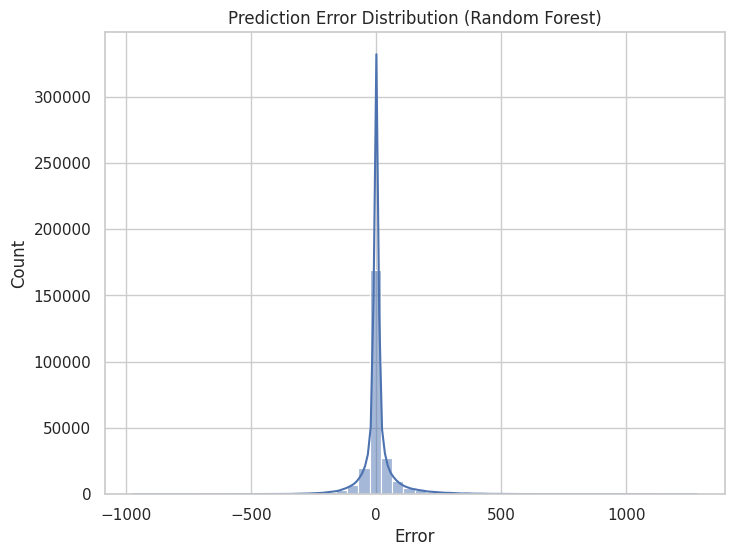

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from category_encoders import TargetEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Configuration
DATA_PATH = 'wfp_food_prices_database.csv'
TEST_SIZE = 0.2
RANDOM_STATE = 42

# 1. Load data
print('Loading data...')
df = pd.read_csv(DATA_PATH, low_memory=False)

# 2. Preprocessing
drop_cols = ["mp_commoditysource", "adm0_name", "adm1_name", "mkt_name", "cur_name", "pt_name", "um_name"]
df = df.drop(columns=drop_cols, errors='ignore')

df = df[df['mp_price'] > 0].reset_index(drop=True)

Q1 = df['mp_price'].quantile(0.25)
Q3 = df['mp_price'].quantile(0.75)
IQR = Q3 - Q1
lower, upper = Q1 - 1.0 * IQR, Q3 + 1.0 * IQR
df = df[(df['mp_price'] >= lower) & (df['mp_price'] <= upper)].reset_index(drop=True)

# Feature engineering
df['mp_month_sin'] = np.sin(2 * np.pi * df['mp_month'] / 12)
df['mp_month_cos'] = np.cos(2 * np.pi * df['mp_month'] / 12)
df['adm1_mean_price'] = df.groupby('adm1_id')['mp_price'].transform('mean')

# 3. Prepare features and target
features = ['adm1_id', 'cm_id', 'cur_id', 'pt_id', 'um_id',
            'mp_month_sin', 'mp_month_cos', 'mp_year', 'adm1_mean_price']
target = 'mp_price'
X_raw = df[features].copy()
y_raw = df[target]

id_cols = ['adm1_id', 'cm_id', 'cur_id', 'pt_id', 'um_id']
for col in id_cols:
    X_raw[col] = X_raw[col].astype(str)

clip_val = y_raw.quantile(0.99)
y_log = np.log1p(y_raw.clip(lower=1e-6, upper=clip_val))

# 4. Preprocessing pipeline
numeric_feats = ['mp_month_sin', 'mp_month_cos', 'mp_year', 'adm1_mean_price']
cat_feats = id_cols
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_feats),
    ('cat', TargetEncoder(min_samples_leaf=10, smoothing=5), cat_feats)
])
pipeline = Pipeline([('pre', preprocessor)])
print('Fitting preprocessing...')
X_processed = pipeline.fit_transform(X_raw, y_log)

# 5. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_log, test_size=TEST_SIZE, random_state=RANDOM_STATE
)
print(f'Train shape: {X_train.shape}, Test shape: {X_test.shape}')

# 6. Grid search for Random Forest
param_grid = {'n_estimators': [50, 100], 'max_depth': [10, 20]}
grid_search = GridSearchCV(RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1),
                           param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
print('Running Grid Search...')
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print(f'Best parameters: {grid_search.best_params_}')

# 7. Predict and evaluate
y_pred_log = best_model.predict(X_test)
y_true = np.expm1(y_test)
y_pred = np.expm1(y_pred_log)

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)
print('Random Forest Model Performance:', f'MAE={mae:.2f}', f'RMSE={rmse:.2f}', f'R2={r2:.4f}')

# 8. Save results
with open('results_rf.txt', 'w') as f:
    f.write('Random Forest Model Performance:\n')
    f.write(f'MAE: {mae:.2f}\n')
    f.write(f'RMSE: {rmse:.2f}\n')
    f.write(f'R2: {r2:.4f}\n\n')
    f.write(f'Best Parameters: {grid_search.best_params_}\n')

# 9. Visualizations
sns.set(style='whitegrid')

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_true, y=y_pred, alpha=0.3)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel('True Price')
plt.ylabel('Predicted Price')
plt.title('True vs Predicted Prices (Random Forest)')
plt.savefig('rf_true_vs_pred.png')

errors = y_true - y_pred
plt.figure(figsize=(8,6))
sns.histplot(errors, bins=50, kde=True)
plt.xlabel('Error')
plt.title('Prediction Error Distribution (Random Forest)')
plt.savefig('rf_error_distribution.png')

print('Results saved to results_rf.txt and plots saved as PNG files.')
